# Time Series Forecasting for the Global Price of APSP Crude Oil

### Theory
The SARIMAX function from the statsmodels package is an extension of the ARIMA function and combines seasonal (S), Autoregressive (AR), integreated (I), and Moving Average (MA) processes with exogenous (X) factors in order to construct forecasts. AR processes use a linear combination of past values to predict the future values. MA processes use a linear combination of previous period errror terms, or white noise terms which are normally distributed with mean 0 and variance $\sigma^2$, to predict the current period's value. Both AR and MA processes use regression coefficents which are generated using the training portion of the data. Seasonality, integration, and exogenous components are included in the SARIMAX function in order to capture dynamics of the series that pure ARMA models do not account for. Seasonality accounts for periodic activity on a specified frequency. Integration accounts for data which is not stationary, having the same mean and variance, and allows for differencing in order to enfore stationarity. MA processes are all stationary, while AR processes must be differenced in order to achieve stationarity. Exogenous components are included in order to account for variables which are not autoregressed on. 

### Constructing the SARIMAX 

#### Autoregressive (AR)

$$ X_t = \sum_{j=1}^p \phi_j X_{t-j} + \omega_t $$

Where a point $X$ at time $t$ can be represented by the sum from $j=1$ (representing one lag) to $p$ (total lags) of $\phi_j$ the vector of model generated coefficents multiplied by the series value at time $t-j$ plus  $\omega_t$ the white noise term for period $t$. The order of the series is defined by the $p$ value.  

#### Moving Average (MA)

$$X_t = \omega_t + \sum_{j=1}^q\theta_j\omega_{t-j}$$

Where a point $X$ at time $t$ can be represented by $\omega_t$ the white noise term for period $t$ plus the sum from $j=1$ (representing one lag) to $q$ (total lags) of $\theta_j$ the vector of model generated coefficents multiplied by $\omega_{t-j}$ the white noise term or error at $t-j$. The order of the series is defined by the $q$ value.  

#### Autoregressive Moving Average (ARMA)

$$ X_t = \sum_{j=1}^p \phi_j X_{t-j} + \sum_{j=1}^q\theta_j\omega_{t-j} + \omega_t$$

The ARMA process is a linear combination of the AR and MA processes.

#### Autoregressive Integrated Moving Average (ARIMA)

The integreation operator $\Delta^d$ is used to deal with non-stationary series. The order of differencing is represented by $d$ where $X_{t}^{[0]} = X_t$. The differenced series $X_t^{[d]} = \Delta^dX_t$ will now be used to form the ARIMA model. 

$$ X_t^{[d]} = \sum_{j=1}^p \phi_j X_{t-j}^{[d]} + \sum_{j=1}^q\theta_j\omega_{t-j}^{[d]} + \omega_t^{[d]}$$

#### Seasonal Autoregressive Integrated Moving Average (SARIMA)

A time series $X_t$ which exhibits seasonality $s$, is modeled through SARIMA and takes in $P,Q$ seasonal lags. Applying the operator $\Delta_s^D$ where $D$ refers to the number of differences applied to seasonal lags, a point $X_t$ can be predicted. The seasonal operator applies an ARIMA process to previous periods with integer multiples of the seasonal pattern. 

$$ \Delta_s^DX_t^{[d]} = \sum_{j=1}^p \phi_j \Delta_s^D X_{t-j}^{[d]} + \sum_{j=1}^q\theta_j\Delta_s^D \omega_{t-j}^{[d]} + \Delta_s^D \omega_t^{[d]}$$

#### Seasonal Autoregressive Integrated Moving Average with Exogenous Variables (SARIMAX)

The SARIMAX function corrects for exogenous variables that are not autoregressed on. The model accounts for $n$ exogenous variables at time $t$ denoted $Y_t^i$ by adding the sum from $i=1$ to $n$ of the coefficent $\beta_i$ multiplied by $Y_t^i$.

$$ \Delta_s^DX_t^{[d]} = \sum_{j=1}^p \phi_j \Delta_s^D X_{t-j}^{[d]} + \sum_{j=1}^q\theta_j\Delta_s^D \omega_{t-j}^{[d]} + \Delta_s^D \omega_t^{[d]} + \sum_{i=1}^n\beta_iY_t^i$$

### Importing Libraries and Data

In [1]:
import pandas_datareader as pdr
import datetime
import numpy as np

In [2]:
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
#get data
poil = pd.read_csv('POILAPSPUSDM.csv')

In [4]:
print(poil.head())

         DATE  POILAPSPUSDM
0  1990-01-01     20.365072
1  1990-02-01     19.528833
2  1990-03-01     18.220758
3  1990-04-01     16.567778
4  1990-05-01     16.587536


In [5]:
poil.size

786

In [6]:
print(poil.columns)

Index(['DATE', 'POILAPSPUSDM'], dtype='object')


In [7]:
#set date to data frame index in order to use stats tools
poil.index = pd.to_datetime(poil['DATE'], format='%Y-%m-%d')

In [8]:
del poil['DATE'] 

### Plotting Data

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
sns.set()

Text(0.5, 1.0, 'Monthy APSP Oil Prices since 1990')

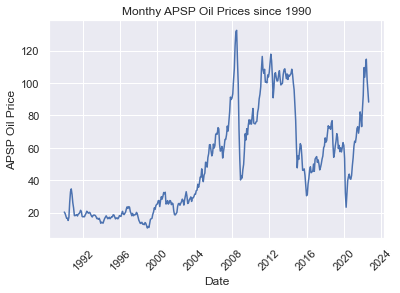

In [11]:
plt.ylabel('APSP Oil Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(poil.index, poil['POILAPSPUSDM'], )
plt.title("Monthy APSP Oil Prices since 1990")

### Checking Stationarity

In [12]:
from statsmodels.tsa.stattools import adfuller
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

In [13]:
check_stationarity(poil)

The series is NOT stationary


Based on the stationarity test, the data will need to be differenced. I attempt a guess and check method to fit my model.

### Splitting the Data for Training and Testing

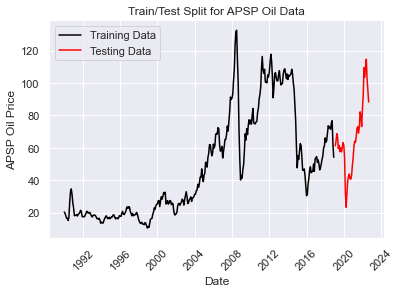

In [14]:
#splitting data for model training/model testing
train = poil[poil.index < pd.to_datetime("2019-01-01", format='%Y-%m-%d')]
test = poil[poil.index > pd.to_datetime("2019-01-01", format='%Y-%m-%d')]
 
#plotting split data
plt.plot(train, color = "black",label = 'Training Data')
plt.plot(test, color = "red",label = 'Testing Data')
plt.ylabel('APSP Oil Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test Split for APSP Oil Data")
plt.legend()
plt.show() #remove show part in order to add in additonal forecasting information

### Forming and Plotting Initial Forecast using ARMA Model

In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [16]:
y = train['POILAPSPUSDM']

In [17]:
ARMAmodel = SARIMAX(y)

/Users/mayadye/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/mayadye/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [25]:
ARMAmodel = SARIMAX(y, order = (1,0,1)) #AR(1), 0 difference, MA(1)

/Users/mayadye/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/mayadye/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [19]:
ARMAmodel = ARMAmodel.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.84282D+00    |proj g|=  8.93121D-02

At iterate    5    f=  2.83872D+00    |proj g|=  3.82581D-04

At iterate   10    f=  2.83854D+00    |proj g|=  6.76807D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     18      1     0     0   2.743D-06   2.838D+00
  F =   2.8384960009804403     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


In [20]:
y_pred = ARMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) #95% confidence interval
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"]

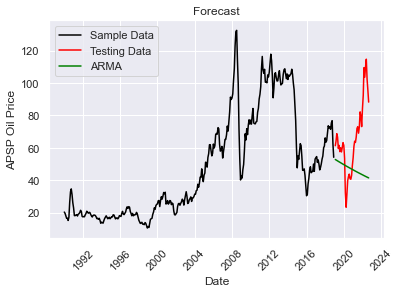

In [21]:
plt.plot(train, color = "black", label = 'Sample Data')
plt.plot(test, color = "red", label = 'Testing Data')
plt.ylabel('APSP Oil Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Forecast")
plt.plot(y_pred_out, color='green', label = 'ARMA')
plt.legend()

### Evaluating Forecast

In [22]:
from sklearn.metrics import mean_squared_error

In [23]:
arma_rmse = np.sqrt(mean_squared_error(test['POILAPSPUSDM'].values, y_pred_df["Predictions"]))
print("Root Mean Square Error: ",arma_rmse)

Root Mean Square Error:  30.78145306934668


The root mean square error (RMSE) evaultes how far the forecast values are from realized values.  The RMSE confirms what the figure above demonstrates: the forecast values are not accurately predicting future prices. Following this test, new dynamics will be introduced in order to produce a more accurate forecast.  The aim is to reduce the RMSE. 

$$ RMSE = \sqrt{\frac{\sum_{i=1}^N(x_i-\hat{x_i})^2}{N}}$$

### Testing ARIMA Model

In [24]:
from statsmodels.tsa.arima.model import ARIMA

In [117]:
ARIMAmodel = ARIMA(y, order = (2,2,2)) #AR(2),second difference,MA(2)
ARIMAmodel = ARIMAmodel.fit()

y_pred1 = ARIMAmodel.get_forecast(len(test.index))
y_pred_df1 = y_pred1.conf_int(alpha = 0.05) #95% confidence interval
y_pred_df1["Predictions"] = ARIMAmodel.predict(start = y_pred_df1.index[0], end = y_pred_df1.index[-1])
y_pred_df1.index = test.index
y_pred_out1 = y_pred_df1["Predictions"]

/Users/mayadye/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/mayadye/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/mayadye/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


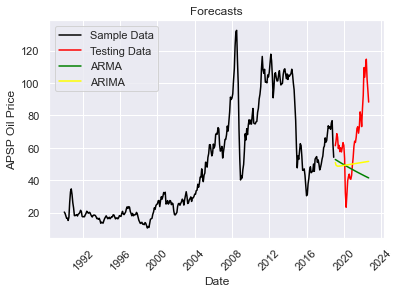

In [118]:
plt.plot(train, color = "black", label = 'Sample Data')
plt.plot(test, color = "red", label = 'Testing Data')
plt.ylabel('APSP Oil Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Forecasts")
plt.plot(y_pred_out, color='green', label = 'ARMA')
plt.plot(y_pred_out1, color='Yellow', label = 'ARIMA')
plt.legend()

In [119]:
arima_rmse = np.sqrt(mean_squared_error(test['POILAPSPUSDM'].values, y_pred_df1["Predictions"]))
print("Root Mean Square Error: ",arima_rmse)

Root Mean Square Error:  26.512767561117492


The RMSE was reduced after indroducing additional dynamics and differencing to the model.  Further testing to follow.

/Users/mayadye/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/mayadye/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/mayadye/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Root Mean Square Error:  22.873889862805665


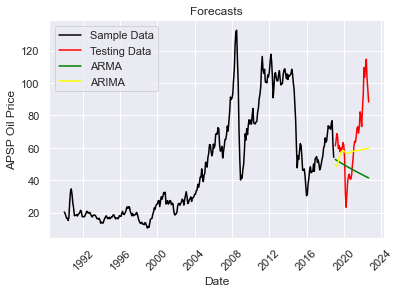

In [120]:
ARIMAmodel = ARIMA(y, order = (10,2,2)) #AR(10), second difference, MA(2)
ARIMAmodel = ARIMAmodel.fit()

y_pred1 = ARIMAmodel.get_forecast(len(test.index))
y_pred_df1 = y_pred1.conf_int(alpha = 0.05) #95% confidence interval
y_pred_df1["Predictions"] = ARIMAmodel.predict(start = y_pred_df1.index[0], end = y_pred_df1.index[-1])
y_pred_df1.index = test.index
y_pred_out1 = y_pred_df1["Predictions"]

plt.plot(train, color = "black", label = 'Sample Data')
plt.plot(test, color = "red", label = 'Testing Data')
plt.ylabel('APSP Oil Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Forecasts")
plt.plot(y_pred_out, color='green', label = 'ARMA')
plt.plot(y_pred_out1, color='Yellow', label = 'ARIMA')
plt.legend()

arima_rmse = np.sqrt(mean_squared_error(test['POILAPSPUSDM'].values, y_pred_df1["Predictions"]))
print("Root Mean Square Error: ",arima_rmse)

After testing different parameters, the model showed a lowest RMSE when using an AR(10), MA(2), and twice differencing.  The model still appears inaccurate and more dynamics should be included.  

### Testing SARIMAX Model

/Users/mayadye/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/mayadye/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27303D+00    |proj g|=  2.49221D-01

At iterate    5    f=  3.05932D+00    |proj g|=  8.04463D-02

At iterate   10    f=  2.99300D+00    |proj g|=  1.20589D-02

At iterate   15    f=  2.99034D+00    |proj g|=  1.52303D-03

At iterate   20    f=  2.92726D+00    |proj g|=  1.66054D-01

At iterate   25    f=  2.88732D+00    |proj g|=  1.91809D-02

At iterate   30    f=  2.88256D+00    |proj g|=  3.71287D-04

At iterate   35    f=  2.88231D+00    |proj g|=  9.98503D-04

At iterate   40    f=  2.88229D+00    |proj g|=  1.69317D-04

At iterate   45    f=  2.88223D+00    |proj g|=  7.58268D-03

At iterate   50    f=  2.88214D+00    |proj g|=  2.77181D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/mayadye/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Root Mean Square Error:  19.619027594246607


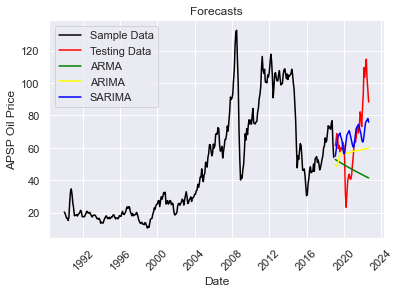

In [121]:
SARIMAXmodel = SARIMAX(y,seasonal_order=(2,2,2,12))
SARIMAXmodel = SARIMAXmodel.fit()

y_pred2 = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df2 = y_pred2.conf_int(alpha = 0.05) 
y_pred_df2["Predictions"] = SARIMAXmodel.predict(start = y_pred_df2.index[0], end = y_pred_df2.index[-1])
y_pred_df2.index = test.index
y_pred_out2 = y_pred_df2["Predictions"] 

plt.plot(train, color = "black", label = 'Sample Data')
plt.plot(test, color = "red", label = 'Testing Data')
plt.ylabel('APSP Oil Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Forecasts")
plt.plot(y_pred_out, color='green', label = 'ARMA')
plt.plot(y_pred_out1, color='Yellow', label = 'ARIMA')
plt.plot(y_pred_out2, color='Blue', label = 'SARIMA')
plt.legend()

sarima_rmse = np.sqrt(mean_squared_error(test['POILAPSPUSDM'].values, y_pred_df2["Predictions"]))
print("Root Mean Square Error: ",sarima_rmse)

### Results

The lowest root mean square error was produced by an SARIMAX model with order AR(1), no differencing, no MA component and seasonal order AR(2), twice differenced, MA(2), and a monthy sesaonal pattern. The seasonal order of the model indicates that the global price of APSP crude oil follows a monthy pattern. The series is approximated by looking at an ARIMA process on a monthly cycle which takes into account two past periods and their error terms. The series requires twice differencing on the seasonal level in order to achieve stationarity. The order indicates that outside of the monthly cycle, the remaining dynamics of the series are best modeled by the previous period's value. The results may be affected by the large fluctuation in price that crude oil experiences from 2019 to 2022.  

### Further Study

In order to improve the forecast, more accurate parameter selection should be introduced by looking at the dynamics of the series before forecasting. The optimal level of differencing can be found by manually differencing the series and performing the augmented Dickey Fuller test. The partial autocorrelation and autocorrelation functions can be generatd using the statsmodels and used to find the AR, MA, and seasonal orders of the series. An algorithm can be implemented to optimize potential AR, MA, and seasonal orders. Additionally, the quality of the forecast can be measured by methods outside of RMSE.

### Resources
- https://builtin.com/data-science/time-series-forecasting-python
- https://www.statology.org/dickey-fuller-test-python/
- https://fred.stlouisfed.org/series/POILAPSPUSDM
- https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html
- https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_forecasting.html
- https://phosgene89.github.io/sarima.html
- https://math.unm.edu/~ghuerta/tseries/week4_1.pdf